Followed pipeline for the development of the article : [On Extracting Digitized Spiral Dynamics’ Representations: A Study on Transfer Learning for Early Alzheimer’s Detection](https://www.mdpi.com/2306-5354/9/8/375)



This work proposes a decision-aid tool for detecting Alzheimer’s disease (AD) at an early stage, based on the Archimedes spiral, executed on a Wacom digitizer. 

 in this work, we propose:


- A novel embedding of dynamic parameters, each encoded separately in different images of a same spiral, providing different “views” of the spiral image (different types of “hybrid“ images).
- A comprehensive study on which dynamic parameters are more discriminant at the classification step, for AD detection. Indeed, we study in this framework of transfer learning different dynamic parameters never studied before in the literature.
- A comparative study on features automatically extracted at different levels of representation by transfer learning; this study is carried out on a reference architecture in the area of neurodegenerative diseases’ assessment, namely AlexNet.
- A complete study on the scope of fusion. Our approach allows new possibilities for fusing dynamic information: at input images (low-level fusion, at the feature level (on representations extracted with AlexNet), and at the experts’ decision level.


Experiments on 30 AD patients and 45 healthy controls (HC) show that the extracted features allow a significant improvement in sensitivity and accuracy, compared to raw images. 

**Note:** This notebook serves as an illustrative way to understand the pipeline followed in the study. For this purpose, only one of the 5 dynamics studied is shown. The pressure is chosen.

# Load Libraries

In [ ]:
import os 
import numpy as np
import pandas as pd

# plot
import matplotlib.pyplot as plt
from matplotlib import colors
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib.collections import LineCollection

# Clustering
from sklearn.cluster import KMeans

# Transfer Learning Pytorch
import torch
import torch.nn as nn
from tensorflow.keras.utils import load_img, img_to_array
from torchsummary import summary
from torchvision import models, transforms
import sklearn

# SVM Classification
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

In [ ]:
# Mounting Google Drive Locally to Colab
from google.colab import drive
drive.mount("/content/drive")

In [ ]:
PATH_DATA = '' # Private Dataset 
PATH_IMG = ''
PATH_FEAT = ''
PATH_RESULT = ''

# Load dataset

Private dataset acquired at Broca Hospital in Paris, in the framework of the
ALWRITE project, a French research project on handwriting analysis for early AD
assessment. 

- Participants drew an Archimedes’ spiral  with an inking pen on a sheet of paper put on top of the tablet. 

<center><img src="https://upload.wikimedia.org/wikipedia/commons/c/c5/Archimedean_spiral.svg" width="250"/><center>


- The tablet sampled the pen trajectory and captured 5 raw temporal functions: pen position (x(t), y(t)), pen pressure p(t), and two pen inclination angles, namely azimuth Az(t) and altitude Alt(t).


<center><img src="https://drive.google.com/uc?export=view&id=1MghJd3WpopKhhJS6bf5gbFJXKda8X30K" width="300"/><center>




- Input format: One .txt file per patient with metadata and the feature information by coulumns (time (t), x(t), y(t), p(t), az(t),alt(t)).

In [ ]:
# List of AD people
list_ad = os.listdir(os.path.join(PATH_DATA, 'AD'))
list_ad = sorted(list_ad)

# List of HC people
list_hc=os.listdir(os.path.join(PATH_DATA, 'HC'))
list_hc = sorted(list_hc)

## Preprocesssing

In [ ]:
thresholdCrop = 6200

def cropping_AD(num,df, dynamic) :   

  '''
  This function returns the values of the position (x,y) describing the spiral and those of the dynamics of interest. 
  Penups that are isolated from the region of interest (the spiral) tend to distort the resulting image, therefore they are eliminated. 

  Arguments:
  - num : int with number of the patient
  - df : dataframe with patient information
  - Dynamique: str with the dynamic information of interest 

  Returns:
  - Necesary values to generate the spiral image : x,y, dynamic 

  '''

  x = df.X             
  y = df.Y

  if dynamic == 'altitude' :
    d = df.Al
  elif dynamic== 'azimuth' :
    d = df.Az
  elif dynamic == 'pressure':
    d = df.P
  else:
    d = df.Ti # necessary for the computation of velocity and acceleration

  # Focus on the spiral draw

  idx = np.where(x < thresholdCrop)[0]  # index of points x<6200
  x_crop = x[idx]                  # x values for x<6200
  y_crop = y[idx]                  # y values for x<6200
  d_crop = d[idx]                  # d values for x<6200

  return x_crop,y_crop,d_crop

# Spiral image generation

For the image generation,different images are generated to represent each feature:

- Raw pen down (points with pressure = 0 are not considered).
- Pressure
- Altitude
- Velocity
- Acceleration

In order to add the dynamic information of each person directly into the drawing, two quantization methods are tested: A pointwise mapping, and a cluster mapping.

A grayscale colormap is used to represent the value of the dynamic.

## Pointwise 



The followed pipeline for each dynamic is based on the same steps, this way a detailed explanation of the pressure image generation is presented.

1. Load the raw data (.txt with the information: t, x(t), y(t), p(t), az(t),alt(t)): Here all the pressure values (AD + HC) are appended to a data frame (df_all).

In [ ]:
def loadGroup(group, dynamic):
  dynamicValues = np.array([])
  for i, name in enumerate(os.listdir(os.path.join(PATH_DATA,group))):
    df = pd.read_csv(os.path.join(PATH_DATA,group, name), delimiter = ' ', header = None)
    df.columns=['Ti','X','Y', 'P','Az', 'Al']
    # x(t),y(t), c(t) as dynamic value to be introduced to the image
    x, y, d = cropping_AD(num = i,
                          df = df,
                          dynamic = dynamic) 
      
    dynamicValues = np.append(dynamicValues,np.array(d))

  return dynamicValues

In [ ]:
ADvalues = loadGroup(group = 'AD',
          dynamic = 'pressure')
HCvalues = loadGroup(group = 'HC',
          dynamic = 'pressure')

ALLvalues = np.concatenate((ADvalues,HCvalues))
# check len 
print(ALLvalues.shape)



2. The pressure values are normalized to 0-1 (note: 0 values corresponds to pen-ups in the trajectory) 



In [ ]:
# Normalization of dynamic values
ALLvaluesNorm = (ALLvalues/ALLvalues.max())
sns.displot(ALLvaluesNorm);

3. The [0-1] are mapped to the grayscale colormap

In [ ]:
# Use of grayscale map 
cmap = plt.cm.get_cmap('Greys')
colors = cmap(ALLvaluesNorm)



4. By taking the points corresponding to each person, their spiral is generated using a scatter plot.
where x,y is the respective pen position (obtained from the original .txt file) and Colors is assigned to 'c'.

5. The image is saved in the pixel size of the Alexnet input, for later feature extraction.

In [ ]:
def saveImages(group, dynamic, labels):
  for i, name in enumerate(os.listdir(os.path.join(PATH_DATA,group))):
    plt.figure(figsize=(693/300, 693/300), dpi=300)
    df = pd.read_csv(os.path.join(PATH_DATA,group, name), delimiter = ' ', header = None)
    df.columns=['Ti','X','Y', 'P','Az', 'Al']
    # x(t),y(t)
    x, y, _ = cropping_AD(num = i,
                          df = df,
                          Dynamic = dynamic) 

      
    C = labels[:len(x)]      # Total labels, so only exploit the corresponding index
    labels = labels[len(x):] # For the next labels, initialize in this way

    plt.scatter(x, y, c=C, s=1, marker=".")
    plt.axis("off")
    plt.savefig(os.path.join(PATH_IMG, 'Images',dynamic, group, group[0] +'_'+ str(i+1).zfill(4) + '.png'))
    plt.title(str(i+1))

    return 

In [ ]:
saveImages(group = 'AD',
           dynamic = 'pressure',
           labels = colors)

saveImages(group = 'HC',
           dynamic = 'pressure',
           labels = colors)

Example of resulting spirals:

<center><img src="https://drive.google.com/uc?export=view&id=1lCVS4RVn3-2z1jP51PQoxMoEA51arWsj" width="800"/><center>



## Clustering

In [ ]:
idxUp = np.where(ALLvalues==0)[0]    # extract penup values (pressure == 0)
idxDown = np.where(ALLvalues>0)[0]   # extract pendown values (pressure > 0)
# check len
print('Total Pendown:', ALLvalues[idxDown].shape, 'Total PenUp:',ALLvalues[idxUp].shape)

A P0K2 Cuantization is performed : 2 pendown pressure levels + penups

In [ ]:
kmeans = KMeans(n_clusters=2) 
data_k = ALLvalues[idxDown]   # data without P=0 values
kmeans.fit(data_k.reshape(-1,1))
y_kmeans = kmeans.predict(data_k.reshape(-1,1))

In [ ]:
centers = kmeans.cluster_centers_
print(centers)
labels = kmeans.labels_  # lower 1, higher 0
# label = 0 will be used por penups (pressure = 0 ) that's why a shift is made 
labels_k = labels + 1
labels_total = np.zeros((len(ALLvalues)))

In [ ]:
for i,idx in enumerate(idxDown) :
  labels_total[idx] = labels_k[i]
  # to check result
  if i < 5 :
    print(idx,labels_total[idx],labels_k[i])

In [ ]:
mapColors = {
    0 :'whitesmoke', #0: Penups
    1 : 'black',     #1: High pressure 
    2 :'gainsboro'   #2: Low pressure 
}

clusterColors = list(map(lambda x: mapColors[x],labels_total))

In [ ]:
saveImages(group = 'AD',
           dynamic = 'pressureP0K2',
           labels = clusterColors)

saveImages(group = 'HC',
           dynamic = 'pressureP0K2',
           labels = clusterColors)

### Study of Clustering Results

The results show that Alzheimer's patients tend to have lower blood pressure, due to the loss of motor function.

In [ ]:
lbl_ad=clusterColors[:len(ADvalues)]
lbl_hc=clusterColors[len(HCvalues):]
plt.rcParams["axes.grid.axis"] ="y"
plt.rcParams["axes.grid"] = True

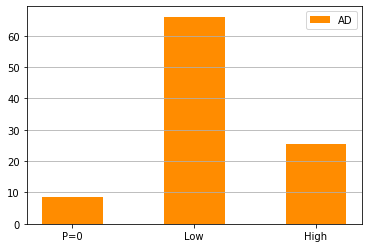

In [ ]:
#### AD #####
lbl_ad = np.array(lbl_ad)
penups = len(np.where(lbl_ad=='whitesmoke')[0]) # element is 0 index
high = len(np.where(lbl_ad=='black')[0]) # element is 2 index
low = len(np.where(lbl_ad=='gainsboro')[0]) # element is 1 index

penups=penups*100/len(ADvalues)
high=high*100/len(ADvalues)
low=low*100/len(ADvalues)

values=[penups,low,high]
levels=['P=0','Low','High']
#plt.grid(axis='y')
plt.bar(levels, values, width=0.5,color='darkorange',label='AD')
plt.legend();

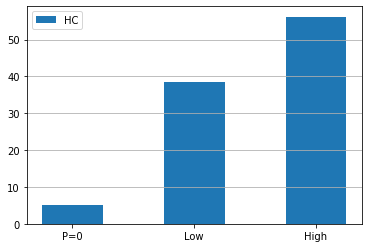

In [ ]:
#### HC #####
lbl_hc=np.array(lbl_hc)
penups = len(np.where(lbl_hc=='whitesmoke')[0]) # element is 0 index
high = len(np.where(lbl_hc=='black')[0]) # element is 2 index
low = len(np.where(lbl_hc=='gainsboro')[0]) # element is 1 index

penups=penups*100/len(HCvalues)
high=high*100/len(HCvalues)
low=low*100/len(HCvalues)

values=[penups,low,high]
levels=['P=0','Low','High']
plt.bar(levels, values, width=0.5,label='HC');
plt.legend();


# Feature extraction

## Notes on Evaluation vs Training modes Pytorch

`model.train()` and `model.eval()` will switch the internal `self.training` flag, which would then change the behavior of some layers. 

E.g. dropout layers will be disabled during evaluation and batchnorm layers will use the running stats instead of the batch statistics to normalize the activation. 
 
**The gradient computation will not be changed or disabled.**

Backpropagation and thus the gradient calculation will also work after calling `model.eval()` but as previously described the forward pass will be different > The affine parameters (weight and bias) will still be trained (can be updated) and will get gradients. 

For the same input, the output of the model after calling `model.eval()` is expected to be the same (up to numerical precision) as long as no parameter updates were performed.

The gradient calculation does not influence the output tensors (of course up to numerical precision).

In [ ]:
# Check on the operation of dropout layers

drop = nn.Dropout()
x = torch.ones(1, 10)

# Train mode (default after construction)
drop.train()
print(drop(x))

# Eval mode
drop.eval()
print(drop(x))

tensor([[0., 2., 0., 0., 0., 2., 2., 2., 2., 2.]])
tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])


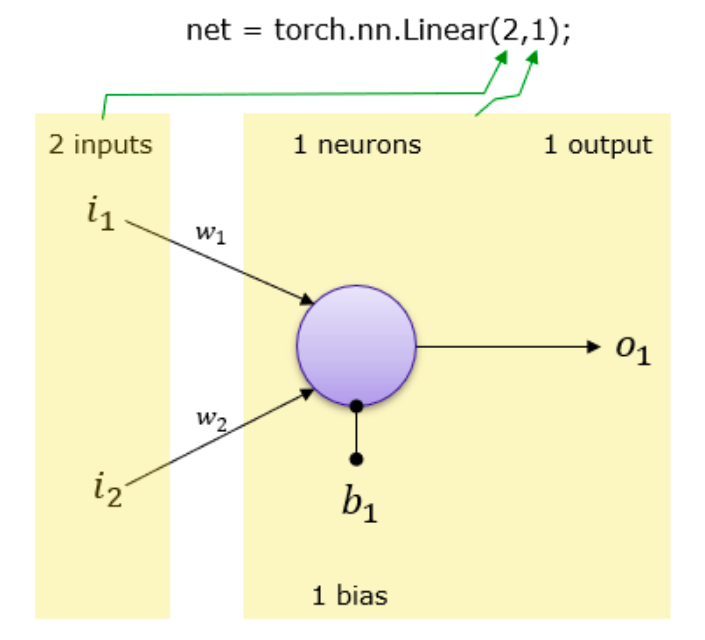

In [ ]:
# Check the effect of backpropagation 

model = nn.Linear(1, 1) # (input size, output size)
x = torch.randn(1, 1)

for _ in range(5):
    out = model(x)
    print(out)
    print('Weight gradient \n',model.weight.grad)
    print('Bias gradient :\n',model.bias.grad)
    out.backward() # compute gradients

tensor([[0.1250]], grad_fn=<AddmmBackward0>)
Weight gradient 
 None
Bias gradient :
 None
tensor([[0.1250]], grad_fn=<AddmmBackward0>)
Weight gradient 
 tensor([[1.7556]])
Bias gradient :
 tensor([1.])
tensor([[0.1250]], grad_fn=<AddmmBackward0>)
Weight gradient 
 tensor([[3.5111]])
Bias gradient :
 tensor([2.])
tensor([[0.1250]], grad_fn=<AddmmBackward0>)
Weight gradient 
 tensor([[5.2667]])
Bias gradient :
 tensor([3.])
tensor([[0.1250]], grad_fn=<AddmmBackward0>)
Weight gradient 
 tensor([[7.0223]])
Bias gradient :
 tensor([4.])


## Pre-processing of the image

In [ ]:
def resize_img(im):
  
  width, height = im.size   # Get dimensions

  new_height = 227
  new_width = 227

  left = (width - new_width)/2
  top = (height - new_height)/2
  right = (width + new_width)/2
  bottom = (height + new_height)/2

  # Crop the center of the image
  img = im.crop((left, top, right, bottom))
  width, height = img.size
  return img

In [ ]:
# Image to feed into the network

def image_to_net(img):
  img = resize_img(img)
  print(img.size)
  img = img_to_array(img)  # numpy array representation of the image
  img= img / 255           # Normalize the image
  print(img.dtype)
  # creation du tensor 
  t = torch.from_numpy(img)    # torch.Size([227,227,3])
  # permutation du tensor pour avoir [ chanel, width, height ]
  t = t.permute(2,0,1)        # torch.Size([3, 227, 227])
  # ajout du batch à 1 élément le tensor aura donc [ Nbatch, chanel, width, height] / Create a mini-batch as expected by the model
  inputs = t.unsqueeze(0)     # torch.Size([1, 3, 227, 227])
  print(inputs.shape)
  print(inputs.dtype)
  return inputs

## AlexNet

Following the Pytorch implementation of AlexNet: https://pytorch.org/hub/pytorch_vision_alexnet/


<center><img src="https://neurohive.io/wp-content/uploads/2018/10/AlexNet-1.png" width="600"/><center>



In [ ]:
def transfer_learning(layer,dynamique):
  path = os.path.join(PATH_IMG, dynamique)

  for root, dirs, files in os.walk(path): 
    files.sort()
    print(root,dirs)

    for img in files:
      if img.endswith(".png"):
        print(img)
        image = load_img(os.path.join(root,img))
      # Input follows the "NCHW" format.
      # forward to the model
        f = alexNet(image_to_net(image))                     
        ft = f[0].detach().numpy()
        ft = ft.ravel()
      # save the features
        if(img[0] == 'A'):
          np.save(os.path.join(PATH_FEAT,layer,dynamique+"AD"+i[:-4]+'.npy'), ft,allow_pickle=True)
        else:
          np.save(os.path.join(PATH_FEAT,layer,dynamique+"HC"+i[:-4]+'.npy'), ft,allow_pickle=True)

In [ ]:
def transfer_learning_fusion(layer,dynamiques):
  # Make the new images (one dynamique per channel)
  fusion_img = np.empty((75,227,227,3))
  for dynamique in dynamiques:
    path = PATH_IMG+dynamique
    img_name,images = [],[]
    for root, dirs, files in os.walk(path): 
      files.sort()
      print(root,dirs)
      for img in files:
        if img.endswith(".png"):
          img_name.append(img)
          image = load_img(os.path.join(root,img))
          img = resize_img(image)
          img = img_to_array(img)   # numpy array representation of the image
          img= img / 255            # Normalize the image
          images.append(img[:,:,0]) # take just one channel
    if dynamique == 'Pressure':
      fusion_img[:,:,:,0] = images
    elif dynamique == 'Altitude':
      fusion_img[:,:,:,1] = images
    else:
      fusion_img[:,:,:,2] = images

  for img in range(len(img_name)):
    # creation du tensor 
    t = torch.from_numpy(fusion_img[img,:,:,:])    # torch.Size([227,227,3])
    # permutation du tensor pour avoir [ chanel, width, height ]
    t = t.permute(2,0,1)        # torch.Size([3, 227, 227])
    # ajout du batch à 1 élément le tensor aura donc [ Nbatch, chanel, width, height] / Create a mini-batch as expected by the model
    inputs = t.unsqueeze(0)     # torch.Size([1, 3, 227, 227])
    inputs = inputs.float()  # convert to float 32
    # forward le model
    f = alexNet(inputs)                     
    ft = f[0].detach().numpy()
    ft = ft.ravel()
    # save features
    if( img_name[i][0] == 'A'):
      np.save(os.path.join(PATH_FEAT,layer,'Fusion' +"AD"+i[:-4]+'.npy'), ft,allow_pickle=True)
    else:
      np.save(os.path.join(PATH_FEAT,layer,'Fusion' +"HC"+i[:-4]+'.npy'), ft,allow_pickle=True)

### Fc7

In [ ]:
 # Fc7
layer = 'Fc7'
alexNet = models.alexnet(pretrained=True)
new_classifier = nn.Sequential(*list(alexNet.classifier.children())[:-1])
alexNet.classifier = new_classifier
alexNet.eval()

# Freeze model parameters
for param in alexNet.parameters():
    param.requires_grad = False

summary(alexNet,(3,227,227))

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 56, 56]          23,296
              ReLU-2           [-1, 64, 56, 56]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
AdaptiveAvgPool2d-14            [-1, 25

In [ ]:
# Extract features Fc7
transfer_learning(layer = layer, dynamique = 'Pressure')
#transfer_learning_fusion(layer = layer, dynamiques = ['Pressure','Altitude','Velocity'])

### From Conv1 to Conv5

In [ ]:
def extractFeatures(layer, idxLayer, dynamique):
  alexNet = models.alexnet(pretrained=True) 
  alexNet = alexNet.features[0:idxLayer]  
  alexNet.eval()

  # Freeze model parameters
  for param in alexNet.parameters():
      param.requires_grad = False
  summary(alexNet,(3,227,227))
  # Extract features
  transfer_learning(layer = layer,dynamique = dynamique)

In [ ]:
idxLayers = {
    'Conv5': 13,
    'Conv4': 10,
    'Conv3': 8,
    'Conv2': 6,
    'Conv1': 3,
}

for layer, idxLayer in idxLayers.items():
  extractFeatures(idxLayer)

# SVM classification

SVM classifier RBF Kernel (Grid SearchCV)

- 10 trials of 30AD  + 30HC  =  Train (20AD + 20HC) Test (10AD + 10HC)

<center><img src="https://drive.google.com/uc?export=view&id=1MPS1cw5TBtEatjnuDgasXbceDWhoeWnB" width="800"/><center>


In [ ]:
ind_ad = []
for i in range(10) :    # 10 samplings from 30 AD
  ind_ad.append(np.random.permutation(30))

ind_hc = []
for i in range(10) :    # 10 samplings of 30/45 from HC
  ind_hc.append(np.random.permutation(45)[:30])

y_train = np.concatenate((np.ones(20,),np.zeros(20,)), axis=None)
y_test = np.concatenate((np.ones(10,),np.zeros(10,)), axis=None)
print(y_train.shape,y_test.shape)

In [ ]:
# Get features 

layerFeatures = {
    'Fc7' : 4096,
    'Conv5' : 9216,
    'Conv4' : 43264,
    'Conv3' : 64896,
    'Conv2' : 32448,
    'Conv1': 46656
}

def getFeatures(group, layer, layerFeatures):
  for file in os.listdir(os.path.join(PATH_FEAT, layer, group)):
    features = np.array([])
    if file.endswith('.npy'):
      print(file)
      features = np.append(features, np.load(file))
  if group == 'AD':
    features = features.reshape(30, layerFeatures[layer])
  else:
    features = features.reshape(45,layerFeatures[layer])

  return features

In [ ]:
# Example for Fc7 layer
ad = getFeatures(group = 'AD',
                 layer = 'Fc7', 
                 layerFeatures = layerFeatures)

hc = getFeatures(group = 'HC',
                 layer = 'Fc7', 
                 layerFeatures = layerFeatures)

## GridSearchCV Optimization

In [ ]:
# Train

def gridSearchSVM(ad,hc):
  parameters = {'gamma':[1e-3,2e-3,1e-4,1.5e-4,1e-5,1.5e-5], 'C':[0.01,0.1,1,10,100,1000,5000,10000]}
  scores = ['accuracy'] # 'fc1', 'recall'
  bestParams=[]
  for j in range(10): # 10 trials 
    print('Run %i'% (j))
    # Select training set
    X_train = np.concatenate((ad[ind_ad[j][:20]],hc[ind_hc[j][:20]]),axis=0)

    for score in scores:
      print("# Tuning hyper-parameters for %s" %score)

      clf = GridSearchCV(SVC(),parameters,scoring='%s' % score)
      clf.fit(X_train, y_train)

      print("Best parameters set found on validation set:")
      print(clf.best_params_)
      bestParams.append(clf.best_params_)
      print()

  return bestParams

In [ ]:
# Test with the best found hyperparameters 
hyperParams = gridSearchSVM(ad = ad, hc = hc)
spe, sen, acc, ypred = [], [], [], []

for j in range(10): # 10 trials 
  X_train = np.concatenate((ad[ind_ad[j][:20]],hc[ind_hc[j][:20]]),axis=0)
  X_test = np.concatenate((ad[ind_ad[j][20:]],hc[ind_hc[j][20:]]),axis=0)

  ### Classification code ###
  model = SVC(C=hyperParams[j]["C"],gamma=hyperParams[j]["gamma"])
  model.fit(X_train,y_train)
  y_pred = model.predict(X_test)
  
  tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
  ypred.append(y_pred)

  spe.append(tn/(tn+fp))
  sen.append(tp/(tp+fn))
  acc.append((tp+tn)/(tp+tn+fn+fp))
print('Average Specificity: %.2f Sensitivity: %.2f Accuracy: %.2f' % (np.mean(spe)*100, np.mean(sen)*100, np.mean(acc)*100))

In [ ]:
# Save results
os.chdir("/content/drive/MyDrive/Results")
np.save(os.path.join(PATH_RESULT, 'pre_fc7_ypred.npy'),ypred,allow_pickle=True) 
np.save(os.path.join(PATH_RESULT, 'pre_fc7_spe.npy'),spe,allow_pickle=True)
np.save(os.path.join(PATH_RESULT, 'pre_fc7_sen.npy'),sen,allow_pickle=True)
np.save(os.path.join(PATH_RESULT, 'pre_fc7_acc.npy'),acc,allow_pickle=True)

# Results and Analysis

The present study proposes a novel scheme for the automatic assessment of early-stage AD, based on Archimedes’ spiral. It exploits transfer learning for feature extraction on “hybrid” spiral images, which convey dynamic information of the handwritten gesture.

Being the main conclusions:

- When embedding dynamic parameters in the spiral trajectory, we first remark a strong improvement of the average sensitivity, from 62% on the raw image to 77% with pressure (Table 2).

<center><img src="https://drive.google.com/uc?export=view&id=1bEKGDwxN4kMGsqWBzm5ezqpV8GugUwc8" width="800"/><center>


<center><img src="https://drive.google.com/uc?export=view&id=1RDGvGSiM0hXhw5iY_wX_WFHIzFovk86y" width="800"/><center>


- Our methodology leads to more balanced average sensitivity and specificity values: on raw images, we note a difference of 25% between specificity (87%) and sensitivity (62%), while on hybrid images such difference is significantly reduced.

- The work also shows that such improvements required studying representations
extracted by the network at different layers. Indeed, on raw images, fc7 gives the best accuracy, with high specificity at the price of a very low sensitivity. For hybrid images, in general, we obtain instead Conv3 discriminant descriptors that strike a better balance between sensitivity and specificity: it is the case for pressure, altitude, and velocity images.



For more detailed information, as well as a complete analysis of results (dynamics and fusion at feature and decision level), we invite you to read the article available at: https://www.mdpi.com/2306-5354/9/8/375
